# Semi-supervised image classification using local label propagation

- Aydan Jiwani (email redacted)
- Bill Li (email redacted)
- Simhon Chourasa (email redacted)

## Contributions

- Aydan: abstract, parts of methodology, conclusion and LLP debugging
- Bill: parts of methodology/training, supervised and weighted-knn procedures
- Simhon: introduction, parts of methodology/training, LLP implementation

# Abstract

The goal of this project is to develop a semi-supervised learning framework for image classification tasks, focusing on leveraging both labelled and unlabelled data to improve model performance where labelled data is limited. The methodology employs a combination of label propagation and clustering techniques to effectively utilize the unlabelled data and refine the model predictions. Specifically, the project implements a Local Label Propagation (LLP) algorithm described in https://arxiv.org/pdf/1905.11581.pdf, which assigns “pseudolabels” from labelled data to unlabelled data based on their feature similarities. To ensure robust label propagation, we combine cross entropy loss on propagated labels with unsupervised K-means clustering loss. We use the CIFAR-10 dataset for training and validation, and a pretrained ResNet18 model for the base classifier.



## Code libraries
- Numpy - Used for matrix operations
- Matplotlib - Used for graphing
- Pytorch - Used for ResNet, data loading, and various neural network tools
- Sklearn - Used for calculating centroids for K-Means clustering loss




## Introduction

As described in [1], training with Local Label Propagation works in two steps:
For each input image, we use our model to generate both a prediction of the classification of the image and the embedding from the second-last layer in the model (the layer before the final fully-connected one).
For each of the unlabelled data points, we assign a pseudo-label to it using a method similar to K-nearest neighbours (k-NN), and get a confidence value associated with that pseudo-label. We can then train the model on unlabelled samples with a loss proportional to that confidence value, with the loss function being composed of both cross-entropy and aggregation loss (details below).

## Methodology

We use the same basic model for all of our testing, which has Resnet-18 as a base model and replaces the final fully-connected layer of the Resnet architecture with a fully-connected layer with the desired output size of 10, corresponding to the number of classes in the dataset.

To compare the efficacy of LLP against strictly supervised learning, we learn on the same dataset but with different proportions of the data being labelled. Specifically, we tried learning with 5%, 10%, and 25% of the 50 000 images in the training data being labelled.

To get a baseline measurement, we perform supervised learning on only the labelled datapoints. We then looked at the weighted KNN semi-supervised approach, which predicts pseudolabels for unlabelled points based on their local proximity with labelled points. These predictions are sourced from the last feature layer (d=128) before the fully connected layer.

First, the probability that a given feature vector $ v$ will be identified as an example $ i$ is given by the following non-parametric softmax function as suggested in [2]:

\begin{align*}
	P(i | v) = \frac{\exp(v_i^T v / \tau)}{\sum_{j = 1}^N \exp(v_j^T v / \tau)}
\end{align*}

where $\tau$ is a temperature hyperparameter.

A weight for each pseudo-labelled vector as each class, $w(v, j)$ (which is the weight for pseudo-labelled vector v as class j) is determined with the following equation:

\begin{align*}
	w(v, j) = \sum_{i \in I_j} P(i | v)
\end{align*}

where $I_j$ is the classes of the vectors in the subset of the k-nearest neighbours of $v$ which have class $j, and $v_i$ is the $i^{\text{th}}$ vector corresponding to that neighbour.

The corresponding probability $p(v, j)$ that the vector v is of class j is defined as:

\begin{align*}
	p(v, j) = \frac{w(v, j)}{\sum_{k=1}^{10} w(v, k)}
\end{align*}

The associated pseudolabel $y$ and confidence score $c$ is obtained as such:

\begin{align*}
	y = \arg \max_j p(v, j),
  c = p(v, y)
\end{align*}

The local label propagation method determines pseudolabels in a similar fashion: First, a weight for each pseudo-labelled vector as each class, $w(i, j)$ (which is the weight for pseudo-labelled vector i as class j) is determined with the following equation:

\begin{align*}
	w(v, j) = \sum_{i \in I_j} \frac{P(i | v)}{\rho(v_i},
\end{align*}

The term $\rho(v_i) = \Sigma_{j \in N_T (v_i)} {P(j|v_i)}$ is a measure of local embedding density equal to the probability $v_i$ belongs to the class of one of the T nearest neighbours.


For the weighted KNN and LLP approaches, in addition to the standard cross-entropy loss function used for classification, we also made use of aggregation loss to allow the unlabelled datapoints to impact the embedding vectors. As suggested in the project description, we made use of K-means clustering, with a loss function of $\Sigma^{N}_{i=1}  \Sigma^{K}_{k=1} s_{ik} || z_i - \mu_k||^2$.

## Training

For all training, we used a stochastic gradient descent optimizer with a learning rate of $0.001$ for supervised learning, and a learning rate of $0.0001$ for semi-supervised learning. While [1] uses a much higher learning rate of $0.03$, it also has a learning rate dampening factor, and training is done in stages with the learning rate dropping drastically when the validation performance reaches a plateau. Due to our computation limitations, we were unable to train for many epochs, and decided to train for less epochs with a larger learning rate, without the other mechanisms to have learning rate drop off. We found that training converged in some way even without learning rate dampening or other such measures, and so this was considered a reasonable compromise. We trained each model for 5 epochs.

We chose the hyperparameters for the number of nearest-neighbours to look at for KNN and LLP to be $K = 5$ and $T = 10$, which deviates from the paper, due to the chosen dataset having only 10 classes.


# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torchvision.datasets as datasets
from torchvision.models import ResNet18_Weights

from sklearn.cluster import KMeans

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

In [3]:
# TODO: create more datasets

UNLABELLED = -1

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Load CIFAR-10 datasets
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_valid = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def generate_indices(dataset, pct_labelled=0.1):
    num_samples = int(pct_labelled * len(dataset))
    return torch.randperm(len(dataset))[:num_samples]

# Define datasets for fully supervised learning

# 10% of data labelled
indices_10 = generate_indices(cifar_train, 0.1)
full_dataset_10 = torch.utils.data.Subset(cifar_train, indices_10)
full_loader_10 = DataLoader(full_dataset_10, batch_size=128, shuffle=True, num_workers=2)

# 5% of data labelled
indices_05 = generate_indices(cifar_train, 0.05)
full_dataset_05 = torch.utils.data.Subset(cifar_train, indices_05)
full_loader_05 = DataLoader(full_dataset_05, batch_size=128, shuffle=True, num_workers=2)

# 25% of data labelled
indices_25 = generate_indices(cifar_train, 0.25)
full_dataset_25 = torch.utils.data.Subset(cifar_train, indices_25)
full_loader_25 = DataLoader(full_dataset_25, batch_size=128, shuffle=True, num_workers=2)

loader_valid = DataLoader(cifar_valid, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12693992.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # initialize weights to make training easier (via transfer learning)
        self.model.fc = nn.Identity()
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        features = self.model(x)
        x = self.fc(features)
        return x, features

# Supervised learning

We want to see how well we can do without using the unlabelled data points at all, with a simple supervised model only on that subset of data. This will be the baseline against which we will compare. As stated earlier, we will do this with subsets of labelled data comprising 1%, 5%, and 10% of the data.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


models = [Model() for i in range(3)]
names = ["25% labelled", "5% labelled", "10% labelled"]
data_loaders = [full_loader_25, full_loader_05, full_loader_10]
losses = [[] for i in range(3)]

for model_idx in range(3):
    criterion = nn.CrossEntropyLoss()

    full_model = models[model_idx]

    full_model.train()
    full_model.to(device)

    optimizer = torch.optim.SGD(full_model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 5

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(tqdm(data_loaders[model_idx])):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, features = full_model(images)

            loss = criterion(outputs, labels)
            losses[model_idx].append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print statistics
        print(f"{names[model_idx]} -- Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")



  0%|          | 0/98 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


25% labelled -- Epoch 1/5, Loss: 0.7079


100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


25% labelled -- Epoch 2/5, Loss: 0.4516


100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


25% labelled -- Epoch 3/5, Loss: 0.3191


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


25% labelled -- Epoch 4/5, Loss: 0.2583


100%|██████████| 98/98 [00:39<00:00,  2.45it/s]


25% labelled -- Epoch 5/5, Loss: 0.1470


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


5% labelled -- Epoch 1/5, Loss: 1.9391


100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


5% labelled -- Epoch 2/5, Loss: 1.4959


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


5% labelled -- Epoch 3/5, Loss: 1.0096


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


5% labelled -- Epoch 4/5, Loss: 0.7878


100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


5% labelled -- Epoch 5/5, Loss: 0.5180


100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


10% labelled -- Epoch 1/5, Loss: 1.4469


100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


10% labelled -- Epoch 2/5, Loss: 0.7835


100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


10% labelled -- Epoch 3/5, Loss: 1.2853


100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


10% labelled -- Epoch 4/5, Loss: 1.1441


100%|██████████| 40/40 [00:15<00:00,  2.62it/s]

10% labelled -- Epoch 5/5, Loss: 0.8316


Text(0.5, 1.0, 'Supervised training loss- 10%')

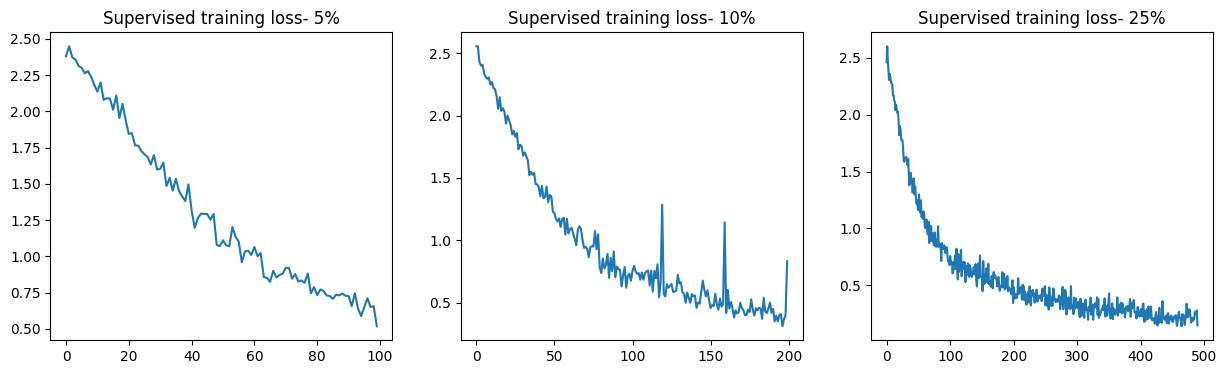

In [ ]:
fig = plt.figure(figsize=(15,4))

plt.subplot(133)
plt.plot(losses[0], label=names[0])
plt.title('Supervised training loss- 25%')
plt.subplot(131)
plt.plot(losses[1], label=names[1])
plt.title('Supervised training loss- 5%')

plt.subplot(132)
plt.plot(losses[2], label=names[2])
plt.title('Supervised training loss- 10%')


In [13]:
# Returns fraction of correct predictions of the model on the given dataset
def evaluate_model(model, data_loader):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
# Evaluate the models
for model_idx in range(3):
    pct_correct_supervised_trained = 100 * evaluate_model(models[model_idx], loader_valid)
    print(f"Accuracy of the supervised model trained on {names[model_idx]} of labels: {pct_correct_supervised_trained} %")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the supervised model trained on 25% labelled of labels: 89.03999999999999 %
Accuracy of the supervised model trained on 5% labelled of labels: 73.89 %
Accuracy of the supervised model trained on 10% labelled of labels: 83.21 %


Of course, we expect an untrained model to be right around 10% of the time, as there are 10 classes.

In [ ]:
# Compared to untrained model

untrained_model = Model()
untrained_model.eval()
untrained_model.to(device)

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = untrained_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of an untrained model : %d %%' % (100 * correct / total))


Accuracy of an untrained model : 10 %


# Semi-supervised learning

In [5]:
# Custom dataset for semi-supervised learning
class SemiSupervised(torch.utils.data.Dataset):
    def __init__(self, labeled_dataset, indices):
        self.labeled_dataset = labeled_dataset
        self.labeled_indices = indices

    def __getitem__(self, index):
        if index in self.labeled_indices:
            return self.labeled_dataset[index]
        else:
            img, label = self.labeled_dataset[index]
            return img, UNLABELLED

    def __len__(self):
        return len(self.labeled_dataset)

# Create semi-supervised datasets
semi_dataset_10 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_10
)

semi_dataset_05 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_05
)

semi_dataset_25 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_25
)

semi_loader_10 = DataLoader(semi_dataset_10, batch_size=128, shuffle=True, num_workers=2)
semi_loader_05 = DataLoader(semi_dataset_05, batch_size=128, shuffle=True, num_workers=2)
semi_loader_25 = DataLoader(semi_dataset_25, batch_size=128, shuffle=True, num_workers=2)

In [6]:
# non-parametric softmax operation by Wu et. al.
# axis 0: v, axis 1: i
def PIV(features, temp):
  upper = torch.exp(torch.matmul(features, features.T) / temp)
  denom = upper.sum(axis=1)
  return upper / denom

def weighted_knn(features, labels, k, temp):
  # Calculate the distances between each pair of points
    mask = torch.where(labels == UNLABELLED)
    unlabelled_features = (features[mask])
    labelled_features = features[labels != UNLABELLED]
    only_labels = labels[labels != UNLABELLED]

    distances = torch.cdist(unlabelled_features, labelled_features, p=2)

    # Find the k nearest neighbors for each point in x
    _, indices = torch.topk(distances, k=min(k, len(only_labels)), largest=False)

    piv = PIV(features, temp)

    weights = torch.zeros((len(mask[0]), 10))
    weights = weights.to(device)

    for i, idxs in enumerate(indices):
      v = mask[0][i]
      for j in idxs:
        weights[i][only_labels[j]] += piv[v, j]

    probs = weights / weights.sum(axis=1)[:, None]

    pseudo_confidence, pseudo_labels = probs.max(axis=1)

    pseudo_labels = pseudo_labels.to(device)
    pseudo_confidence = pseudo_confidence.to(device)

    new_labels = labels.clone()
    new_labels[mask] = pseudo_labels

    confidence = torch.ones_like(labels, dtype=pseudo_confidence.dtype)
    confidence[mask] = pseudo_confidence

    return new_labels, confidence



In [7]:
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(KMeansClusteringLoss, self).__init__()

    def forward(self, features, centroids):
        n = features.shape[0]
        d = features.shape[1]
        k = centroids.shape[0]

        z = features.reshape(n, 1, d)
        z = z.repeat(1, k, 1)

        mu = centroids.reshape(1, k, d)
        mu = mu.repeat(n, 1, 1)

        dist = (z - mu).norm(2, dim=2).reshape((n, k))
        loss = (dist.min(dim=1)[0] ** 2)

        return loss

## Weighted k-nearest neighbors - 10% of labels

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_10 = Model()

semi_model_10.train()
semi_model_10.to(device)

optimizer = torch.optim.SGD(semi_model_10.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.01 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 10
TEMP = 25

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_10(images)

        # pseudo-labelling
        pseudo_labels, confidence = weighted_knn(features, labels, K, TEMP)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        # print('CLUSTER LOSS: ', cluster_loss.mean().item())

        ce_loss = criterion(outputs, pseudo_labels)

        # print('CE LOSS: ', ce_loss.mean().item())

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item():.4f}")



  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:31<00:00,  1.18it/s]


Epoch 1/10, Loss: 1.7275


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:43<00:00,  1.38it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:44<00:00,  1.14it/s]


Epoch 2/10, Loss: 1.0891


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:16<00:00,  1.04it/s]


Epoch 3/10, Loss: 1.0643


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


Epoch 4/10, Loss: 0.9818


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:08<00:00,  1.32it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:08<00:00,  1.06it/s]

Epoch 5/10, Loss: 0.7887


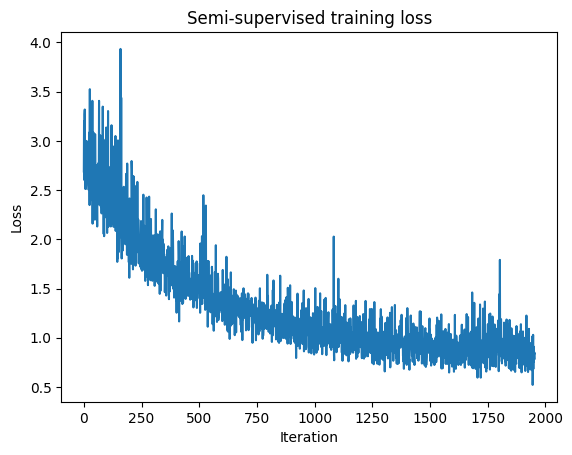

In [ ]:
plt.plot(losses)
plt.title('Semi-supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [ ]:
# Evaluate the model
semi_model_10.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = semi_model_10(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the semi-supervised trained model: %d %%' % (100 * correct / total))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the semi-supervised trained model: 17 %


## Local Label Propagation

In [8]:
def LLP_pv(features, labels, k, T, temp, num_labels=10):
    # Calculate the distances between each pair of points
    mask = torch.where(labels == UNLABELLED)
    unlabelled_features = (features[mask])
    labelled_features = features[labels != UNLABELLED]
    only_labels = labels[labels != UNLABELLED]

    distances = torch.cdist(unlabelled_features, labelled_features, p=2)

    piv = PIV(features, temp)

    weights = torch.zeros((len(mask[0]), num_labels)).to(device)

    rho = torch.zeros(len(unlabelled_features), device=device)
    _, T_nearest_indices = torch.topk(distances, k=min(max(T, K), len(only_labels)), largest=False)

    for vi, tn_to_v_idxs in enumerate(T_nearest_indices):
        for j in tn_to_v_idxs:
          rho[vi] += piv[vi, j]

    for v, v_indices in enumerate(T_nearest_indices[:, :min(K, T_nearest_indices.shape[1])]):
        for j in v_indices:
            weights[v][only_labels[j]] += piv[v, j] / rho[v]

    probs = weights / weights.sum(axis=1)[:, None]
    numerator = torch.exp(weights)
    denominator = torch.sum(numerator, axis=1)
    probs = (numerator.T / denominator).T

    pseudo_confidence, pseudo_labels = probs.max(axis=1)

    pseudo_labels = pseudo_labels.to(device)
    pseudo_confidence = pseudo_confidence.to(device)

    new_labels = labels.clone()
    new_labels[mask] = pseudo_labels

    confidence = torch.ones_like(labels, dtype=pseudo_confidence.dtype)
    confidence[mask] = pseudo_confidence

    return new_labels, confidence

## LLP - 10% of labels


In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_10 = Model()

semi_model_10.train()
semi_model_10.to(device)

optimizer = torch.optim.SGD(semi_model_10.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.0001 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 5
T = 10
TEMP = 50

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_10(images)

        pseudo_labels, confidence = LLP_pv(features, labels, K, T, TEMP, 10)

        features_without_nan = np.nan_to_num(features.cpu().detach().numpy(), 0)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features_without_nan).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        ce_loss = criterion(outputs, pseudo_labels)

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:42<00:00,  1.03s/it]


Epoch 1/10, Loss: 1.5929


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:33<00:00,  1.01s/it]


Epoch 2/10, Loss: 1.1152


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:31<00:00,  1.14it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:31<00:00,  1.00s/it]


Epoch 3/10, Loss: 1.0282


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:29<00:00,  1.00it/s]


Epoch 4/10, Loss: 1.0088


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:47<00:00,  1.04s/it]

Epoch 5/10, Loss: 0.9850


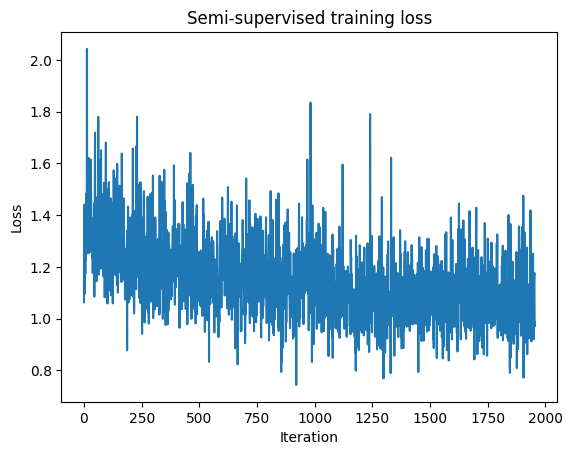

In [ ]:
plt.plot(losses)
plt.title('Semi-supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(semi_model_10, f)

In [ ]:
pct_correct_supervised_trained = 100 * evaluate_model(semi_model_10, loader_valid)
print(f"Accuracy of the supervised model trained on 10% of labels: {pct_correct_supervised_trained} %")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the supervised model trained on 10% of labels: 30.81 %


## LLP - 5% of labels

In [9]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_05 = Model()

semi_model_05.train()
semi_model_05.to(device)

optimizer = torch.optim.SGD(semi_model_05.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.0001 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 5
T = 10
TEMP = 50

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_05)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_05(images)

        # pseudo-labelling
        pseudo_labels, confidence = LLP_pv(features, labels, K, T, TEMP, 10)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        ce_loss = criterion(outputs, pseudo_labels)

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]
  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:28<00:00,  1.01it/s]


Epoch 1/10, Loss: 0.4910


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:03<00:00,  1.23it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:03<00:00,  1.08it/s]


Epoch 2/10, Loss: 0.4712


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:03<00:00,  1.27it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:03<00:00,  1.07it/s]


Epoch 3/10, Loss: 0.5358


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:03<00:00,  1.32it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:03<00:00,  1.08it/s]


Epoch 4/10, Loss: 0.4634


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:00<00:00,  1.08it/s]

Epoch 5/10, Loss: 0.5485


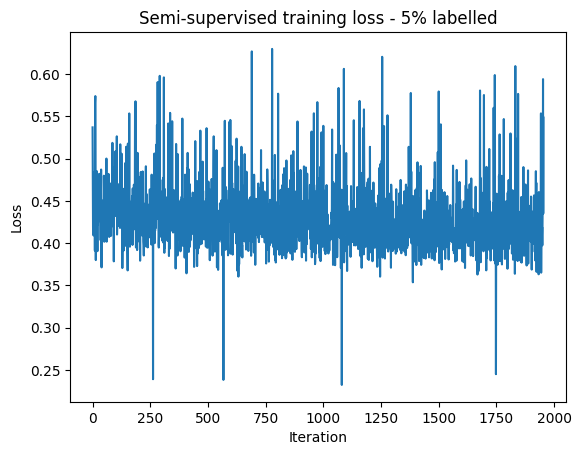

In [10]:
plt.plot(losses)
plt.title('Semi-supervised training loss - 5% labelled')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

Note: this model started with a low loss likely by a mixture of low confidence and pure chance

In [11]:
import pickle

with open('semi_model_05.pkl', 'wb') as f:
    pickle.dump(semi_model_05, f)

In [15]:
pct_correct_semi_05 = 100 * evaluate_model(semi_model_05, loader_valid)
print(f"Accuracy of the supervised model trained on 5% of labels: {pct_correct_semi_05} %")

Accuracy of the supervised model trained on 5% of labels: 29.9 %


## LLP - 25% of labels

In [16]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_25 = Model()

semi_model_25.train()
semi_model_25.to(device)

optimizer = torch.optim.SGD(semi_model_25.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.0001 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 5
T = 10
TEMP = 50

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_25)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_25(images)

        # pseudo-labelling
        pseudo_labels, confidence = LLP_pv(features, labels, K, T, TEMP, 10)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        ce_loss = criterion(outputs, pseudo_labels)

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



100%|██████████| 391/391 [06:16<00:00,  1.04it/s]


Epoch 1/10, Loss: 0.7646


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:13<00:00,  1.05it/s]


Epoch 2/10, Loss: 0.6616


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:19<00:00,  1.03it/s]


Epoch 3/10, Loss: 0.6236


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [07:10<00:00,  1.08it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [07:10<00:00,  1.10s/it]


Epoch 4/10, Loss: 0.5866


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [07:27<00:00,  1.15s/it]

Epoch 5/10, Loss: 0.5042


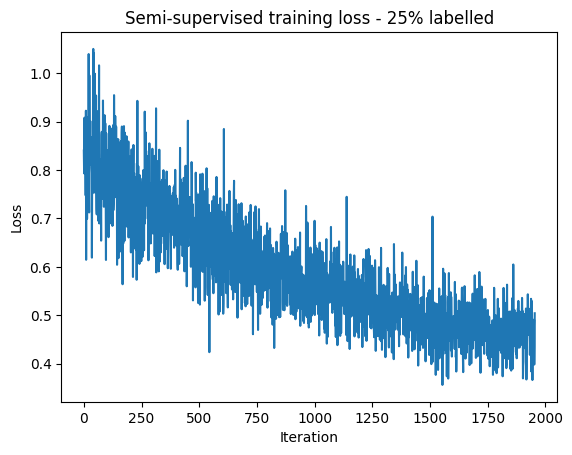

In [17]:
plt.plot(losses)
plt.title('Semi-supervised training loss - 25% labelled')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [18]:
import pickle

with open('semi_model_25.pkl', 'wb') as f:
    pickle.dump(semi_model_25, f)

In [20]:
pct_correct_semi_25 = 100 * evaluate_model(semi_model_25, loader_valid)
print(f"Accuracy of the supervised model trained on 25% of labels: {pct_correct_semi_25} %")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the supervised model trained on 25% of labels: 70.39 %


# Results

Accuracy (%) for supervised learning:
- 5% of labels: 73.89%
- 10% of labels: 83.21%
- 25% of labels: 89.04%

Accuracy (%) for semi-supervised learning (k-NN):
- 10% of labels: 17.00%

Accuracy (%) for semi-supervised learning (LLP):
- 5% of labels: 29.90%
- 10% of labels: 30.81%
- 25% of labels: 70.39%

# Conclusion

The fully supervised model had the best results, as expected due to the large amount of labelled data. We note that the LLP semi-supervised model outperformed the k-means model. The ability to use fully unlabelled data for label propagation allows the use of significantly more training data, resulting in more accurate predictions.

The failure of the k-NN procedure was due to it not utilizing unlabelled points, causing poor density estimations.



Although our LLP model did not reach the performance noted in the paper, one possible explanation for this is the use of CIFAR-10 instead of ImageNet for our data. With 10 classes instead of 1000 in ImageNet, this was a much easier problem to solve that may not have warranted the methods we employed. However, this limitation was necessary due to limited GPU access. Also, using K-Means loss as our clustering loss instead of NLL is another deviation from the paper that created the challenge of tuning between clustering loss and cross entropy loss.

Future improvements to this project would include using a more complex dataset, as well as experimenting with different loss functions and learning rates. The time limit and restrictions imposed by Google Colab also constrained the datasets we could use and the number of epochs we could train for; these limitations also guided us to choose higher learning rate values without learning rate decay, which are likely nonoptimal.


# References

[1] C. Zhuang, X. Ding, D. Murli, and D. Yamins. (2019) Local Label Propagation for Large-Scale
Semi-Supervised Learning. arXiv preprint arXiv:1905.11581v1 [cs.CV].

[2] Wu, Z. et al. (2018) ‘Unsupervised feature learning via non-parametric instance discrimination’, 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition [Preprint]. doi:10.1109/cvpr.2018.00393.
